# Camera Calibration
For accurate transformation of the turbine within the Google Street View image, the derivation of the camera matrix is essential. This matrix computes the necessary transformations to convert between the camera coordinate system and the global coordinate system. The theoretical foundation and calculations in this section draw from the material presented by {cite:t}`computer_vision`.

In [12]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import print_code, intrinsic_parameters, rotation_matrix, extrinsic_parameters, camera_matrix, image_plane
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from IPython.core.display import HTML

To establish a coherent framework, we begin by defining the global coordinate system. In this context, a right-handed coordinate system is employed, wherein positive changes in the x-axis represent longitudinal shifts, positive changes in the y-axis denote latitudinal shifts, and positive changes in the z-direction signify an increase in elevation. 

<img src="../../jupyter-book/images/coord_sys.png" alt="coordinate-system" width="100px" class="bg-primary"/>


*Fig 1: Coordinate system used for the camera matrix calculations.*

## Intrinsic parameters
$K = \begin{bmatrix}
\alpha_x & \gamma & u_0 & 0\\
0 & \alpha_y & v_0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix}$

The $K$ matrix comprises five intrinsic parameters specific to the camera model being used. These parameters encompass essential factors such as the focal length, image sensor format, and camera principal point.

Two of these parameters, $\alpha_x = f \cdot m_x$ and $\alpha_y = f \cdot m_y$, express the focal length in terms of pixels. Here, $m_x$ and $m_y$ represent the inverses of the width and height of a pixel on the projection plane, while $f$ denotes the focal length measured in terms of distance. The skew coefficient between the x and y axes, denoted as $\gamma$, is typically assumed to be 0. The parameters $u_0$ and $v_0$ represent the principal point, ideally located at the center of the image.


In [13]:
f = 0.02 # focal length
shape = [250, 250] # shape of image in pixels
fov = [60, 60]

K = intrinsic_parameters(f, shape, fov)

print(K)

[[216.50635095   0.         125.        ]
 [  0.         216.50635095 125.        ]
 [  0.           0.           1.        ]]


## Extrinsic parameters
### Rotation Matrix
A rotation matrix serves as a transformation matrix employed to execute rotations in space. It facilitates the determination of the necessary rotations for converting between the real-world coordinate system and the camera coordinates by utilizing Euler angles. For instance, following the convention below, the matrix plays a crucial role in this process.

In [14]:
roll = np.deg2rad(90) # roll (X)
pitch = np.deg2rad(0) # tilt (Y)
yaw = np.deg2rad(0) # direction (Z)
theta = np.array([roll, pitch, yaw]) 
R = rotation_matrix(theta, order = "ZYX")
print (R)

[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17]]


### Normalized Camera Matrix
The normalized camera matrix, denoted as $C_N$, serves as a transformation matrix that enables the conversion of 3D points from a global coordinate system to 2D points within a camera coordinate system. It accounts for the displacement between the camera's position and the origin of the global coordinate system.

Mathematically, the matrix can be expressed as:

$C_N = R (I | -ñ)$

Here:

* $R$ represents the rotation matrix that describes the camera's orientation within the global coordinate system.
* $I$ denotes the identity matrix.
* $ñ$ signifies the translation vector that indicates the camera's position within the global coordinate system.


In [15]:
n = np.array([0, 0, 0]) # 3D translation of camera origin and world origin
C_N = extrinsic_parameters(R, n)
print("C_N: \n", C_N)

C_N: 
 [[ 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17  0.000000e+00]]


## Camera Matrix
The camera matrix can be obtained by computing the cross product of the intrinsic and extrinsic parameters. This camera matrix enables a direct conversion between the 3D coordinate system and the 2D screen coordinate system.

In [16]:
HTML(print_code(camera_matrix))

In [17]:
P = camera_matrix(K, C_N)
print("P: \n", P)

P: 
 [[ 2.16506351e+02  1.25000000e+02  7.65404249e-15  0.00000000e+00]
 [ 0.00000000e+00  1.25000000e+02 -2.16506351e+02  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  6.12323400e-17  0.00000000e+00]]


## Test of Function

Let's examine the functions by establishing a point in 3D space. The 2D screen coordinates can be determined through the cross product of the camera matrix and the 3D world coordinates, followed by normalizing the outcome.

In [18]:
HTML(print_code(image_plane))

In [19]:
point_3D_origin = [0, 1, 0]
u, v = image_plane(P, point_3D_origin)
print(f"U: {u:.1f} px\nV: {v:.1f} px")

U: 125.0 px
V: 125.0 px


Let's proceed to calculate the screen coordinates of a point in 3D space, covering the entire process from start to finish.

In [20]:
# INPUTS
f = 0.1 # focal length
shape = [250, 250] # shape of image in pixels
fov = [90, 90]
K = intrinsic_parameters(f, shape, fov)
theta = np.array([np.deg2rad(90), np.deg2rad(0), np.deg2rad(0)]) # roll, pitch, yaw
R = rotation_matrix(theta, order = "XYZ")
camera_origin = np.array([0, 1, 0]) # 3D translation of camera origin and world origin
C_N = extrinsic_parameters(R, camera_origin)
P = camera_matrix(K, C_N)
turbine_origin = np.array([0, 10, 0])
u, v = image_plane(P, turbine_origin)
print(f"U: {u:.1f} px\nV: {v:.1f} px")

U: 125.0 px
V: 125.0 px


To visualize what the camera sees, you can plot the calculated screen coordinates. Here's an example of how you can achieve that:

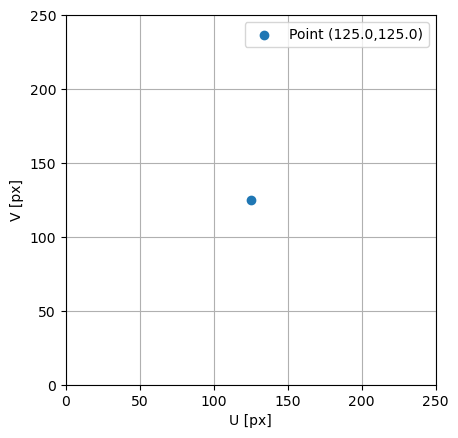

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(u, v, label = f"Point ({u:.1f},{v:.1f})")
ax.set(xlim = [0, shape[0]], 
       ylim = [0, shape[1]],
       xlabel = "U [px]",
       ylabel = "V [px]",
       aspect = "equal")
ax.grid()
ax.legend()
plt.show()

### 3D Model
To visualize the movement of the camera sensor with the rotation of the camera in relation to the world coordinate system, you can create a plot that includes the world origin, camera origin, and a point in 3D space. The plot will also feature a colored surface representing the inverted camera sensor, showing where the 3D point appears on the sensor along the line-of-sight between the camera and the point. If the line does not intersect the sensor, the point should not appear in the image. Here's an example of how you can create such a plot:

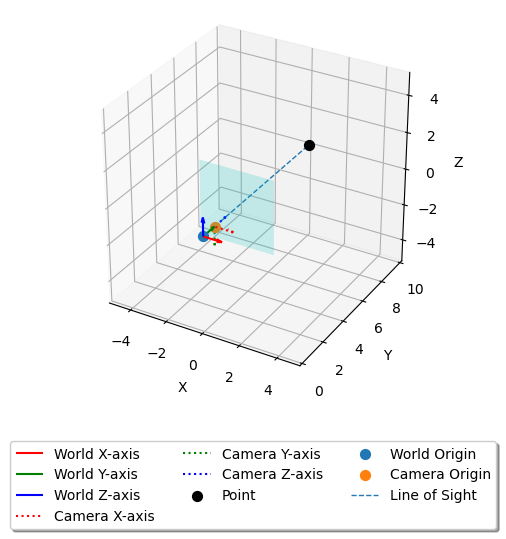

In [22]:
# Create a 3D plot
theta *= -1
R = R.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the origin for world coordinates and unit vectors along the world coordinates
world_origin = [0, 0, 0]
world_x_vector = [1, 0, 0]
world_y_vector = [0, 1, 0]
world_z_vector = [0, 0, 1]

# Define the origin for camera coordinates and unit vectors along the camera coordinates
camera_x_vector = R @ world_x_vector
camera_y_vector = R @ world_y_vector 
camera_z_vector = R @ world_z_vector

# Plot the world coordinate system with labels
ax.quiver(*world_origin, *world_x_vector, color='r', label='World X-axis')
ax.quiver(*world_origin, *world_y_vector, color='g', label='World Y-axis')
ax.quiver(*world_origin, *world_z_vector, color='b', label='World Z-axis')

# Plot the camera coordinate system with labels
ax.quiver(*camera_origin, *camera_x_vector, color='r', label='Camera X-axis', ls = ":")
ax.quiver(*camera_origin, *camera_y_vector, color='g', label='Camera Y-axis', ls = ":")
ax.quiver(*camera_origin, *camera_z_vector, color='b', label='Camera Z-axis', ls = ":")

# Plot the 3D point with a label
ax.scatter(*turbine_origin, c='k', s=50, label='Point')
ax.scatter(*world_origin, s=50, label = "World Origin")
ax.scatter(*camera_origin, s=50, label = "Camera Origin")

#### INPUTS #####
f = 2
vfov = np.deg2rad(90)
hfov = np.deg2rad(90)

vl = 2*np.tan(vfov/2)*f # vertical length
hl = 2*np.tan(hfov/2)*f # horizontal length
zz = f * np.ones([2, 2]) # offset in z
xx, yy = np.meshgrid(np.linspace(-hl/2, hl/2, 2), np.linspace(-vl/2, vl/2, 2))
coord = np.einsum('ij,kj->ki', R, np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) + camera_origin # 'ij,kj->ki'
vertices = [coord[[0, 1, 3]], coord[[0, 2, 3]]]
surface = Poly3DCollection(vertices, alpha=0.2)
surface.set_facecolor('c')
ax.add_collection3d(surface)

ax.plot(*np.array([camera_origin, turbine_origin]).T, linestyle = "dashed", linewidth = 1, label = "Line of Sight")

s = 1
arr = np.array([world_origin, camera_origin, turbine_origin])
min = np.min(arr)/s-1
max = np.max(arr)*s+1

ax.scatter(*-np.array([max]*3)+world_origin, alpha = 0)
ax.scatter(*np.array([max]*3)+world_origin, alpha = 0)

offset = camera_origin - turbine_origin
l = np.sqrt(np.sum(offset**2))

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# set range of plot
coords = np.array([world_origin, turbine_origin])
center = np.mean(coords, axis=0)
max_range = np.max(np.ptp(coords, axis=0))
ax.set_xlim(center[0] - max_range/2, center[0] + max_range/2)
ax.set_ylim(center[1] - max_range/2, center[1] + max_range/2)
ax.set_zlim(center[2] - max_range/2, center[2] + max_range/2)
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.show()